# Multilayer Perceptron from Scratch

## Stage 2 - Implementation 


Author: Natalia Jaśkowska


Topic: Classification of wine with the help of a learned network with a teacher (MLP) 


directory: wine

# Used Modules

In [111]:
import numpy as np
from typing import List, Union, Tuple, Optional, Iterator, Any, Dict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import sklearn.utils
from sklearn.model_selection import StratifiedKFold
from functools import partial
from multiprocessing import Pool
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
sns.set()

# Architecture of a single Layer class

In [112]:
class Layer:
    def __init__(self, hidden_units, activation: Optional[str]=None, random_seed=None):
        """
        Initialize the layer with the specified number of neurons and activation function.

        :param hidden_units: The number of neurons in the layer
        :param activation: The activation function to use (if any). Must be one of [None, 'relu', 'softmax'].
        :param random_seed: Seed for the random number generator, to ensure reproducibility.
        """
        if activation not in [None, 'relu', 'softmax']:
            raise KeyError('wrong activation function')
            
        self.hidden_units = hidden_units
        self.activation = activation
        self.weights = None
        self.biases = None
        self.random_seed = random_seed if random_seed is not None else np.random.randint(0, 2**32 - 1)
    
    def _init_params(self, input_size: int, hidden_units: int):
        """
        Initialize the weights and biases for the layer.

        :param input_size: The number of inputs to the layer
        :param num_neurons: The number of neurons in the layer
        """
        
        self.weights = np.random.RandomState(self.random_seed).randn(input_size, hidden_units) * np.sqrt(2. / input_size)
        self.biases = np.zeros((1, hidden_units)) 
    
    def _apply_activation(self, weighted_inputs: np.ndarray):
        """
        Apply the activation function to the weighted inputs.

        :param weighted_inputs: The weighted inputs to the layer
        :return: The outputs of the layer after applying the activation function
        """
        if self.activation == 'relu':
            return self.relu(weighted_inputs)
        elif self.activation == 'softmax':
            return self.softmax(weighted_inputs)
        else:
            return weighted_inputs  # just return input
        
    def _apply_activation_backward(self, weighted_inputs: np.ndarray, grad: np.ndarray):
        """
        Apply the derivative of the activation function to the weighted inputs, for use in backpropagation.

        :param weighted_inputs: The weighted inputs to the layer
        :param grad: The gradient of the loss function with respect to the outputs of the layer
        :return: The gradient of the loss function with respect to the weighted inputs
        """
        if self.activation == 'relu':
            return self.relu_backward(weighted_inputs, grad)
        elif self.activation == 'softmax':
            return self.softmax_backward(weighted_inputs, grad)
        else:
            return grad  # just return grad
    
    def forward_pass(self, inputs: np.ndarray) -> np.ndarray:
        """
        Perform a forward pass of the data through the layer.

        :param inputs: The input data
        :return: The outputs of the layer
        """
        self.inputs = inputs
        if self.weights is None:
            self._init_params(inputs.shape[-1], self.hidden_units)
        
        self.weighted_inputs = inputs @ self.weights + self.biases
        return self._apply_activation(self.weighted_inputs)
    
    def backward_pass(self, next_layer_grad: np.ndarray) -> np.ndarray:
        """
        Perform a backward pass (backpropagation) of the gradient through the layer.

        :param next_layer_grad: The gradient of the loss function with respect to the outputs of the next layer
        :return: The gradient of the loss function with respect to the inputs of the layer
        """
        da = self._apply_activation_backward(self.weighted_inputs, next_layer_grad)
        db = np.sum(da, axis=0)
        dw = self.inputs.T @ da
        dx = da @ self.weights.T
        return dx, dw, db
    
    @staticmethod
    def softmax(x: np.ndarray, derivative=False) -> np.ndarray:
        x = x - np.max(x)
        s = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        return s
        
    @staticmethod
    def softmax_backward(x: np.ndarray, grad: np.ndarray) -> np.ndarray:
        x = x - np.max(x)
        s = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        
        diag = np.stack([
            np.diag(s[i])
            for i in range(len(s))
        ], 0)
        softmax_grad = diag - np.einsum('bi,bj->bij', s, s)
        # grad: batch_size x class_num
        # softmax_grad: batch_size x class_num x class_num
        return np.einsum('bc,bcd->bd', grad, softmax_grad)
                
    @staticmethod           
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod           
    def relu_backward(x, grad):
        relu_grad = (x >= 0).astype(x.dtype)
        return relu_grad * grad

## Activation functions explained

1. ReLU:

    In this project, I decided to use the ReLU (Rectified Linear Unit) as the activation function in my neural network model. ReLU is a popular choice due to its simplicity and efficiency. Defined as f(x) = max(0, x), it simply passes positive inputs directly while outputting zero for any negative input.

    The use of ReLU in my model is primarily to introduce non-linearity into the network, which enables the model to learn complex patterns from the data. By incorporating ReLU in the network, I have been able to manage and reduce the issue of the **vanishing gradient problem** -- a situation where gradients are close to zero, making the network hard to train.

    Vanishing gradient problem can slow down the training process, or in the worst case compeletly halt the network from further training. The ReLU activation function helps to mitigate this issue because its derivative is always 1 for positive input, which ensures that the gradient does not vanish during the backward propagation.
    
    In the code for this project, I have incorporated ReLU in the `_apply_activation` and `_apply_activation_backward` methods. During the forward pass in the `forward_pass` method, the `_apply_activation` method applies the ReLU function to the weighted inputs if ReLU is specified as the activation function.

    During the backward propagation process, the `_apply_activation_backward` method applies the derivative of the ReLU function to the gradients. This allows the gradient to propagate effectively back through the network during the training phase. It is through these intricacies that I have tailored the network to harness the benefits of the ReLU activation function.

2. Softmax:

    In my project, the Softmax function plays an integral role, particularly in the output layer of the neural network model where I'm dealing with multi-class classification tasks. Softmax serves as an effective way to convert raw scores to probabilities, making the output interpretable and providing a clear prediction result from among multiple classes.

    The Softmax function is defined in a way that for any given input vector, it squashes the vector's elements into the range of [0, 1] and ensures that they all sum up to 1. This property makes Softmax extremely useful when interpreting the outputs as probabilities.
    
    In the code, I have two methods for implementing Softmax: `softmax` for the forward pass and `softmax_backward` for the backward pass. In the `softmax` method, we start by subtracting the maximum value of the input vector from each element. This strategy is used to avoid numerical instability that can occur due to large exponentials.

    After calculating the exponentials, they are normalized by dividing each one by the sum of exponentials, resulting in the final Softmax values. These values represent the probabilities for each class and are used for the prediction.

    The `softmax_backward` method is used during backpropagation. Here, the gradient of the Softmax function is calculated. Given that Softmax is not just applied element-wise like ReLU but involves all elements of its input when calculating the output, its derivative is more complex.

    In this method, I calculate a Jacobian matrix (a matrix of all first-order partial derivatives) for each instance in the batch, subtracting the outer product of the Softmax output with itself from the diagonal matrix of the Softmax output. The output gradient is then calculated by multiplying the incoming gradient with the computed Jacobian.

    This backward pass plays a crucial role during the training phase. The gradients obtained here are used to adjust the weights of the network, thus improving the prediction power of the model iteratively. It's this careful application of the Softmax function and its backward propagation that has helped my network to perform multi-class classification tasks efficiently.
    

# Learning algorithm as backpropagation with SGD with momentum, Adam and AdaGrad optimizers

In my project, I've implemented a Multilayer Perceptron (MLP) neural network and adopted the backpropagation algorithm for training purposes. The backpropagation algorithm is quite fascinating, as it operates by propagating errors back from the output layer to the input layer of the network. By applying the chain rule of calculus, it computes the derivative of the loss function with respect to each parameter in the network, which helps us understand how much a small change in each parameter affects the overall loss.

Interestingly, I decided not to utilize the vanilla version of the backpropagation algorithm, which uses the entire dataset to compute gradients in every iteration. Instead, I implemented the Stochastic Gradient Descent (SGD) with momentum, Adam, and AdaGrad, all variants of gradient descent that use a subset of the data, known as a mini-batch, to compute the gradients.


### Stochastic Gradient Descent with Momentum:

The first variant, SGD with momentum, adds a fraction of the update vector of the past time step to the current update vector. It accelerates SGD by navigating along the relevant directions and softens the oscillation in the irrelevant. It's like a ball rolling downhill, it picks up momentum (speed) in directions with persistent gradients.

Pseudocode:

    Initialize the weights and biases of the neural network randomly
    Initialize velocity v = 0
    for each epoch:
        Shuffle the training dataset
        for each mini-batch:
            Use the model to predict the output
            Compute the gradient of the loss with respect to the weights (dw) and biases (db)
            Compute velocity v = momentum * v - learning_rate * dw
            Update the weights: weights = weights + v
            Update the biases: biases = biases - learning_rate * db
            
### Adam (Adaptive Moment Estimation):

Secondly, I used Adam, a popular and efficient gradient descent optimization algorithm. It's an adaptive learning rate method, which means it computes individual learning rates for different parameters. Its name is derived from "adaptive moment estimation", and it combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.

Pseudocode:

    Initialize the weights and biases of the neural network randomly
    Initialize moving averages of the gradients (m) and squared gradients (v) to 0
    for each epoch:
        Shuffle the training dataset
        for each mini-batch:
            Use the model to predict the output
            Compute the gradient of the loss with respect to the weights (dw) and biases (db)
            Update moving averages of the gradients: m = beta1*m + (1-beta1)*dw
            Update moving averages of the squared gradients: v = beta2*v + (1-beta2)*(dw^2)
            Compute bias-corrected estimates of the moving averages: m_hat = m / (1 - beta1^t), v_hat = v / (1 - beta2^t)
            Update the weights: weights = weights - learning_rate * m_hat / (sqrt(v_hat) + epsilon)
            Update the biases: biases = biases - learning_rate * db

### AdaGrad (Adaptive Gradient Algorithm):

The third optimizer I used is AdaGrad, which stands for Adaptive Gradient Algorithm. The essence of AdaGrad is that it adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters. It is particularly beneficial for dealing with sparse data. However, AdaGrad's learning rate is always decreasing and decaying, which may lead to the early and excessive decrease of the learning rate, causing the algorithm to converge prematurely.

Pseudocode:

    Initialize the weights and biases of the neural network randomly
    Initialize sum of squared gradients (G) to 0
    for each epoch:
        Shuffle the training dataset
        for each mini-batch:
            Use the model to predict the output
            Compute the gradient of the loss with respect to the weights (dw) and biases (db)
            Accumulate squared gradients: G = G + dw^2
            Update the weights: weights = weights - learning_rate * dw / (sqrt(G) + epsilon)
            Update the biases: biases = biases - learning_rate * db


#### Summary:

For each of these optimizers, the workflow begins with initializing the weights and biases of the neural network randomly. After this, the algorithm goes through a series of epochs, where the training set is shuffled and divided into mini-batches. For each mini-batch, the inputs are fed forward through the network, and the output is calculated. The loss between the predicted output and the actual output is then computed. Utilizing backpropagation, the gradients of the loss with respect to the parameters in the network are determined, which in turn updates the weights and biases using a learning rate.

After each epoch, the performance of the model on the validation set is evaluated, and ultimately, the model showcasing the best performance is selected. Each of these optimizers has their own strengths, and using them has significantly improved the efficiency and performance of my MLP model.

### Backpropagation algorithm explained as a function `backward_pass()`:


In all these cases, the specific computation corresponds to the derivative of the layer's output with respect to the parameter in question (either `self.weights`, `self.biases`, or `self.inputs`), which is derived from the rules of differentiation and the specific operations used in the forward pass of this layer. The backpropagation algorithm then uses these gradients to update the layer's parameters in the direction that minimizes the loss function.



- `da`: This is the gradient of the loss function with respect to the pre-activated outputs of the layer. This is computed by applying the derivative of the activation function to `self.weighted_inputs` and then element-wise multiplying it by `next_layer_grad` (i.e., the chain rule is used here).

- `db`: This is the gradient of the loss function with respect to the biases of the layer. It's computed by summing up da across the 0-th axis (i.e., across the batch of instances). This is because during the forward pass, each bias is added to every instance in the input batch, so during backpropagation, we need to sum the gradients across the batch to reflect this.

- `dw`: This is the gradient of the loss function with respect to the weights of the layer. It's computed by the matrix multiplication (denoted by `@` operator) of the transpose of `self.inputs` and `da`. Again, the chain rule is used here.

- `dx`: This is the gradient of the loss function with respect to the inputs of the layer, which will be passed to the previous layer during backpropagation. It's computed by the matrix multiplication of `da` and the transpose of self.weights.

# Optimizer class


In [113]:
class Optimizer:
    """
    This is the base Optimizer class. It has a learning rate parameter which is set at initialization.
    The update method is intended to be overridden by subclasses that implement specific optimization algorithms.
    """
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
    
    def update(self, params, grads):
        """
        This method is intended to be overridden by subclasses to implement parameter update logic.
        """
        raise NotImplementedError
        
class SGD(Optimizer):
    """
    The SGD class implements Stochastic Gradient Descent with momentum. It inherits from the base Optimizer class.
    It has a momentum parameter which is set at initialization. The update method updates each layer's parameters based
    on the gradients and the learning rate, taking momentum into account.
    """
    def __init__(self, learning_rate=0.01, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocity: List[Tuple[np.ndarray, np.ndarray]] = []

    def update(self, layers, grads):
        """
        Updates the parameters of each layer based on the gradients, the learning rate, and momentum.
        """
        if not self.velocity:
            self.velocity = [(np.zeros_like(layer.weights), np.zeros_like(layer.biases)) for layer in layers]

        for (v_w, v_b), layer, (dw, db) in zip(self.velocity, layers, grads):
            v_w *= self.momentum
            v_w += self.learning_rate * dw
            layer.weights -= v_w
            
            v_b *= self.momentum
            v_b += self.learning_rate * db
            layer.biases -= v_b
            
class AdaGrad(Optimizer):
    """
    The AdaGrad class implements the AdaGrad optimization algorithm. It inherits from the base Optimizer class.
    The update method updates each layer's parameters based on the gradients and an adaptive learning rate.
    """
    def __init__(self, learning_rate=0.01, epsilon=1e-7):
        super().__init__(learning_rate)
        self.epsilon = epsilon
        self.accumulated_grads: List[Tuple[np.ndarray, np.ndarray]] = []
    
    def update(self, layers: List[Layer], grads: List[Tuple[np.ndarray, np.ndarray]]):
        """
        Updates the parameters of each layer based on the gradients, the learning rate, and an adaptive term.
        :param layer: list of layers with parameters to update
        :param grads: list of gradients for each layer's parameters
        """
        if not self.accumulated_grads:
            self.accumulated_grads = [(np.zeros_like(layer.weights), np.zeros_like(layer.biases)) for layer in layers]

        for (h_w, h_b), layer, (dw, db) in zip(self.accumulated_grads, layers, grads):
            h_w += dw * dw
            layer.weights -= self.learning_rate * dw / (np.sqrt(h_w) + self.epsilon)
            
            h_b += db * db
            layer.biases -= self.learning_rate * db / (np.sqrt(h_b) + self.epsilon)

class Adam(Optimizer):
    """
    The Adam class implements the Adam optimization algorithm. 
    It inherits from the base Optimizer class. Based on 
    https://optimization.cbe.cornell.edu/index.php?title=Adam 
    """
    def __init__(self, learning_rate: float = 0.001, beta1: float = 0.9, beta2: float = 0.999, epsilon: float = 1e-7):
        """
        Initialize Adam optimizer.
        
        :param learning_rate: learning rate
        :param beta1: The exponential decay rate for the first moment estimates
        :param beta2: The exponential decay rate for the second-moment estimates
        :param epsilon: small value to prevent division by zero
        """
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m: List[Tuple[np.ndarray, np.ndarray]] = []
        self.v: List[Tuple[np.ndarray, np.ndarray]] = []
        self.t = 0
        
    def update(self, layers: List[Layer], grads: List[Tuple[np.ndarray, np.ndarray]]) -> None:
        """
        Perform the Adam update on parameters.

        :param layers: list of layers with parameters to update
        :param grads: list of gradients for each layer's parameters
        """
        if not self.m:
            self.m = [[np.zeros_like(layer.weights), np.zeros_like(layer.biases)] for layer in layers]
            self.v = [[np.zeros_like(layer.weights), np.zeros_like(layer.biases)] for layer in layers]

        self.t += 1

        for (m, v), layer, (dw, db) in zip(zip(self.m, self.v), layers, grads):
            m[0] *= self.beta1
            m[0] += (1.0 - self.beta1) * dw
            bias_corrected_first_moment = m[0] / (1.0 - self.beta1**self.t)
            v[0] *= self.beta2
            v[0] += (1.0 - self.beta2) * dw**2
            bias_corrected_second_moment = v[0] / (1.0 - self.beta2**self.t)
            
            layer.weights -= self.learning_rate * bias_corrected_first_moment / (np.sqrt(bias_corrected_second_moment) + self.epsilon)

            m[1] *= self.beta1
            m[1] += (1.0 - self.beta1) * db
            bias_corrected_first_moment = m[1] / (1.0 - self.beta1**self.t)
            v[1] *= self.beta2
            v[1] += (1.0 - self.beta2) * db**2
            bias_corrected_second_moment = v[1] / (1.0 - self.beta2**self.t)
            
            layer.biases -= self.learning_rate * bias_corrected_first_moment / (np.sqrt(bias_corrected_second_moment) + self.epsilon)

# Artificial Neural Network Architecture

In [124]:
class NeuralNetwork:
    def __init__(self, num_epochs=100, batch_size=32, optimizer=SGD(learning_rate=0.01),
                 activation='relu', hidden_sizes: List[int]=[128], num_classes=4, verbose=False, random_seed=42):
        """
        Initialize a Neural Network with the provided parameters.

        :param num_epochs: Number of epochs for training
        :param batch_size: Size of the mini-batch
        :param optimizer: Optimizer to use for training
        :param activation: Activation function to use in hidden layers
        :param hidden_sizes: List of sizes for each hidden layer
        :param num_classes: Number of output classes
        :param verbose: If True, print training progress
        :param random_seed: Seed for generating random numbers
        """
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.verbose = verbose
        self.batch_size = batch_size
        rng = np.random.RandomState(random_seed)
        self.layers = [Layer(size, activation, random_seed=rng.randint(0, 2**32 - 1)) for size in hidden_sizes]
        self.layers.append(Layer(num_classes, 'softmax', random_seed=rng.randint(0, 2**32 - 1)))
        self.num_classes = num_classes
        
        self.scaler = StandardScaler()
        
    @staticmethod
    def to_one_hot(y: np.ndarray, num_classes: int):
        """
        Convert label vector to one-hot encoded matrix.

        :param y: A 1D numpy array of labels
        :param num_classes: Number of classes
        :return: A 2D numpy array representing the one-hot encoding
        """
        one_hot = np.zeros((y.shape[0], num_classes))
        one_hot[range(y.shape[0]), y] = 1
        return one_hot
    
    def categorical_cross_entropy(self, y_pred: np.ndarray, y_true: np.ndarray, derivative=False) -> Union[float, Tuple[np.ndarray, np.ndarray]]:
        """
        Calculate the categorical cross-entropy loss or its derivative.

        :param y_pred: Predicted output
        :param y_true: Actual labels
        :param derivative: If True, calculate the derivative instead
        :return: Loss value (scalar) or derivative of the loss function
        """
        y_true = self.to_one_hot(y_true, self.num_classes)
        
        # Clip to prevent NaN's and Inf's to prevent log(0) or division by zero:
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if derivative:
            return -y_true / y_pred
            # return 2 * (y_pred - y_true)
        else:
            return -np.sum(y_true * np.log(y_pred), axis=-1)
            # return ((y_true - y_pred) ** 2).sum(-1)
    
    def _create_mini_batches(self, X: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool, drop_last: bool) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        """
        Creates mini-batches from the input data.

        :param X: The input features
        :param y: The target labels
        :param batch_size: The size of the mini-batches
        :param shuffle: If True, the data is shuffled before creating mini-batches
        :param drop_last: If True, the last batch is dropped if its size is smaller than batch_size
        :yield: Mini-batches (X_batch, y_batch)
        """
        if shuffle:
            X, y = sklearn.utils.shuffle(X, y)
        if drop_last:
            n_minibatches = X.shape[0] // batch_size
        else:
            n_minibatches = (X.shape[0] + batch_size - 1) // batch_size
        for i in range(n_minibatches):
            yield X[i * batch_size : (i + 1) * batch_size], y[i * batch_size : (i + 1) * batch_size]
    
    def _forward(self, X: np.ndarray):
        """
        Performs a forward pass throught the neural network.

        :param X: input data
        :return: the output of the last layer of the neural network, necessary to calculate backprop
        """
        if not self.layers:
            raise ValueError("No layers in the neural network.")

        for layer in self.layers:
            X = layer.forward_pass(X)

        return X

    def _backpropagation(self, y_pred: np.ndarray, y_true: np.ndarray):
        """
        Executes the backpropagation algorithm.

        The goal of backpropagation is to compute the gradient of the loss function with respect to the weights of the network,
        which is done by propagating the gradient backwards through the network. The gradients are then used to update the weights and biases to minimize the loss
        :param y_pred: network's output from the forward pass algorithm
        :param y_true: true labels 
        """
        # Calculate the initial gradient as the derivative of the loss function
        grads = []
        dx = self.categorical_cross_entropy(y_pred, y_true, derivative=True)

        for layer in self.layers[::-1]:
            # Calculate the gradient at the current layer
            dx, dw, db = layer.backward_pass(dx)
            grads.append((dw, db))

        grads = grads[::-1]
        self.optimizer.update(self.layers, grads) # Update the weights and biases for all layers

    def _run_single_epoch(self, X: np.ndarray, y: np.ndarray, optimize: bool) -> Tuple[float, float]:
        """
        Run one epoch of forward and backward pass, and computes the accuracy and loss for this epoch.

        :param X: The input data
        :param y: The corresponding labels
        :param optimize: If True, performs optimization (backpropagation)
        :return: The average loss and accuracy for this epoch
        """
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for X_batch, y_batch in self._create_mini_batches(X, y, self.batch_size, shuffle=optimize, drop_last=optimize):
            y_pred = self._forward(X_batch)

            loss = self.categorical_cross_entropy(y_pred, y_batch)
            total_loss += loss.sum()

            correct = self.count_correct_predictions(y_batch, y_pred)
            correct_predictions += correct

            total_samples += len(X_batch)

            if optimize:
                self._backpropagation(y_pred, y_batch)

        average_loss = total_loss / total_samples
        average_accuracy = correct_predictions / total_samples
        
        return average_loss, average_accuracy
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray, X_val: Optional[np.ndarray] = None, y_val: Optional[np.ndarray] = None):
        """
        Train the neural network.

        :param X_train: Training input
        :param y_train: Training labels
        :param X_val: Validation input, if available
        :param y_val: Validation labels, if available
        """
        
        self.history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
        
        X_train = self.scaler.fit_transform(X_train)
        if X_val is not None:
            X_val = self.scaler.transform(X_val)
        
        for epoch in range(self.num_epochs):
            train_loss, train_accuracy = self._run_single_epoch(X_train, y_train, optimize=True)
            self.history['train_loss'].append(train_loss)
            self.history['train_accuracy'].append(train_accuracy)
            
            if X_val is not None and y_val is not None:
                val_loss, val_accuracy = self._run_single_epoch(X_val, y_val, optimize=False)
                self.history['val_loss'].append(val_loss)
                self.history['val_accuracy'].append(val_accuracy)

                if self.verbose:
                    print(f'Epoch {epoch + 1}: '
                          f'train_loss={train_loss} train_accuracy={train_accuracy} '
                          f'val_loss={val_loss} val_accuracy={val_accuracy}')
    
    @staticmethod
    def count_correct_predictions(y_true, y_pred):
        """
        Counts the number of correct predictions.

        :param y_true: true labels
        :param y_pred: predicted labels
        :return: number of correct predictions
        """
        return np.sum(y_true == y_pred.argmax(axis=-1))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Evaluates the network's performance on the provided data.

        :param X: The input data
        :return: class predictions
        """
        X = self.scaler.transform(X)
        y_pred = self._forward(X)
        return y_pred.argmax(-1)        

# Load data


In [115]:
def load_data():
    '''
    Loads wine data and splits them to X and Y
    '''
    data = load_wine()
    return data['data'], data['target'] 

# Split data

 Split the dataset into training and testing sets.
 `X_train` and `y_train` are the features and target for the training set.
  `X_test` and `y_test` are the features and target for the test set.
 The test set size is 30% of the entire dataset.
 A random state seed of 32 is used for reproducibility of results.

In [116]:
from sklearn.model_selection import train_test_split

X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

# Util-functions

In [117]:
def instantialize_from_args(model_args: Dict[str, Any]) -> 'Neural Network':
    """
    Instantiates a Neural Network model from provided arguments.

    :param model_args: dictionary containing arguments for model initialization.
    :return: An instance of the NeuralNetwork class.
    """
    model_args = model_args.copy()
    optim = model_args.pop('optimizer').copy()
    optim_name = optim.pop('name')
    if optim_name == 'SGD':
        opt = SGD(**optim)
    elif optim_name == 'Adam':
        opt = Adam(**optim)
    elif optim_name == 'AdaGrad':
        opt = AdaGrad(**optim)
    else:
        raise ValueError('wrong optimizer')

    return NeuralNetwork(optimizer=opt, **model_args)

In [118]:
def evaluate_model(X: np.ndarray, Y: np.ndarray, model_args: Dict[str, Any], n_splits: int = 5) -> float:
    """
    Evaluates the performance of a model using Stratified K-Fold cross-validation.

    :param X: The feature matrix.
    :param Y: The target vector.
    :param model_args: dictionary containing arguments for model initialization.
    :param n_splits: The number of folds in Stratified K-Fold cross-validation.
    :return: Mean accuracy of the model across all folds.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=model_args.get('random_seed', 0))
    acc = []
    for i, (train_indices, val_indices) in enumerate(skf.split(X, Y)):
        model = instantialize_from_args(model_args)
        model.fit(X[train_indices], Y[train_indices], X[val_indices], Y[val_indices])
        acc.append(model.history['val_accuracy'][-1])
            
    return np.mean(acc)

In [119]:
def random_search(X: np.ndarray, Y: np.ndarray, iterations: int, reps: int, pool: Any = __builtins__) -> Tuple[Dict[str, Any], float]:
    """
    Performs a random search to find best hyperparameters for the model.
    `iterations` different hyperparameters are randomized, and evaluated `reps` times (with different random seeds)
    returns best hyperparameters and accuracy

    :param X: The feature matrix.
    :param Y: The target vector.
    :param iterations: Number of different hyperparameters to randomize.
    :param reps: Number of repetitions for evaluating each set of hyperparameters.
    :param pool: multiprocessing pool for parallel computation.
    :return: Tuple of best hyperparameters and the corresponding accuracy.
    """
    args = [
        dict(hidden_sizes=[round(2 ** np.random.randint(0, 8)) for _ in range(np.random.randint(0, 4))],
             batch_size=np.random.randint(1, 32),
             num_epochs=np.random.randint(1, 100),
             optimizer=np.random.choice([
                 {
                     'name': 'SGD',
                     'learning_rate': 10 ** np.random.normal(-3, 0),
                     'momentum': np.random.uniform(0, 0.99),
                 },
                 {
                     'name': 'Adam',
                     'learning_rate': 10 ** np.random.normal(-3, 0),
                     'beta1': np.random.uniform(0, 0.99),
                     'beta2': np.random.uniform(0, 0.99),
                 },
                 {
                     'name': 'AdaGrad',
                     'learning_rate': 10 ** np.random.normal(-3, 0),
                 },
             ])
        ) for i in range(iterations)
    ]
    accs = np.array([
        list(pool.map(partial(evaluate_model, X, Y), [a | {'random_seed': j} for a in args]))
        for j in range(reps)
    ])
    accs = accs.mean(0)
    i = accs.argmax()
    return args[i], accs[i]

# Find best hyperparameters

In [130]:
THREADS = 24

In [131]:
%%time
with Pool(THREADS) as pool:
    best_args, best_accuracy = random_search(X_train, y_train, iterations=1, reps=32)
best_args, best_accuracy

CPU times: user 10.8 s, sys: 253 ms, total: 11 s
Wall time: 11.1 s


({'hidden_sizes': [4],
  'batch_size': 20,
  'num_epochs': 56,
  'optimizer': {'name': 'Adam',
   'learning_rate': 0.001,
   'beta1': 0.8340152713735364,
   'beta2': 0.511651530185265}},
 0.7626354166666667)

In [132]:
%%time
with Pool(THREADS) as pool:
    best_args, best_accuracy = random_search(X_train, y_train, iterations=1000, reps=32)
best_args, best_accuracy

CPU times: user 6h 41min 3s, sys: 3min 43s, total: 6h 44min 47s
Wall time: 6h 40min 11s


({'hidden_sizes': [128],
  'batch_size': 7,
  'num_epochs': 25,
  'optimizer': {'name': 'Adam',
   'learning_rate': 0.001,
   'beta1': 0.4828766300042446,
   'beta2': 0.9780262776787818}},
 0.9777812499999998)

In this block of code, I've implemented a random search algorithm to optimize the hyperparameters of a model.

To speed up the hyperparameter optimization process, I've utilized Python's multiprocessing module with a specific number of threads, denoted by THREADS. This allows multiple model configurations to be evaluated simultaneously.

The `random_search` function is then run for 1000 iterations, testing different hyperparameters each time. For each set of hyperparameters, the model's performance is evaluated 32 times, denoted by `reps=32`, to provide a more reliable measure of its performance.

The total CPU and wall time are being tracked using the `%%time` magic command. In this instance, the process took nearly 6 hours and 41 minutes of CPU time, and a wall time of 6 hours and 40 minutes.

The hyperparameters that achieved the best performance are: a hidden layer size of 128, a batch size of 7, 25 training epochs, and the Adam optimizer with a learning rate of 0.001 and betas of 0.4828766300042446 and 0.9780262776787818.

The best accuracy achieved with these hyperparameters was approximately 0.9778 or 97.78%, which is quite a high level of accuracy for most predictive tasks. Therefore, these are the hyperparameters I would use for further prediction tasks within this project.

# Evaulate model on best hyperparameters

In [133]:
def eval_and_plot(X: np.ndarray, Y: np.ndarray, model_args: Dict[str, Any], verbose: bool = True):
    """
    Conducts model evaluation using Stratified K-Fold cross-validation and plots 
    the accuracy and loss curves for the training and validation sets.

    :param X: The feature matrix.
    :param Y: The target vector.
    :param model_args: dictionary containing arguments for model initialization.
    :param verbose: If True, prints the best hyperparameters, last training loss, 
                    last validation accuracy and confusion matrix.
    """
    y_pred, y_true = [], []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    history = []
    for i, (train_indices, val_indices) in enumerate(skf.split(X, Y)):
        model = instantialize_from_args(model_args)
        model.fit(X[train_indices], Y[train_indices], X[val_indices], Y[val_indices])
        history.append(model.history)
        
        y_pred.extend(Y[val_indices])
        y_true.extend(model.predict(X[val_indices]))
        
    history = {key: np.mean([h[key] for h in history], 0) for key in history[0].keys()}

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.lineplot(pd.DataFrame(history)[['train_accuracy', 'val_accuracy']])
    plt.ylim(0, 1.05)

    plt.subplot(1, 2, 2)
    sns.lineplot(pd.DataFrame(history)[['train_loss', 'val_loss']])
    plt.ylim(0, 1.05)
    
    if verbose:
        print(f"Evaluate model on best args : {best_args}")
        print(f"train loss: {history['train_loss'][-1]}")
        print(f"val_accuracy: {history['val_accuracy'][-1]}")    
        
        print(ConfusionMatrixDisplay.from_predictions(y_true, y_pred))

Evaluate model on best args : {'hidden_sizes': [128], 'batch_size': 7, 'num_epochs': 25, 'optimizer': {'name': 'Adam', 'learning_rate': 0.001, 'beta1': 0.4828766300042446, 'beta2': 0.9780262776787818}}
train loss: 0.009725009377986028
val_accuracy: 0.9596666666666666


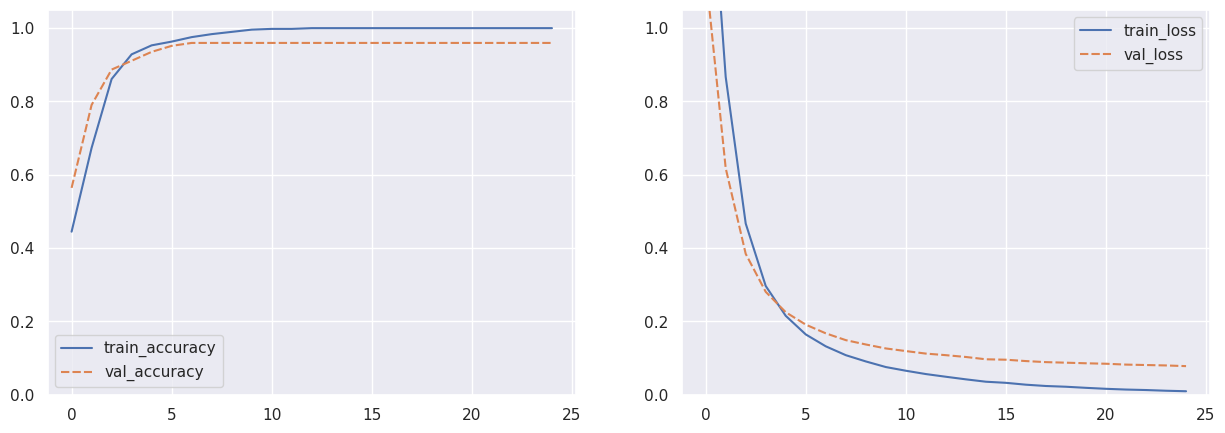

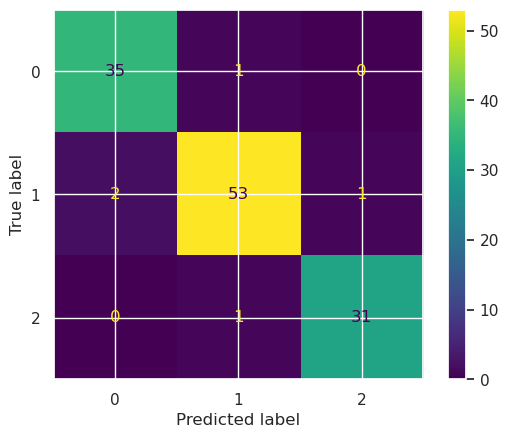

In [134]:
eval_and_plot(X_train, y_train, best_args, verbose=True)

Conclusions:

- We observe a training loss of approximately 0.0097, which is quite low, indicating that the model is fitting the training data well.

- The validation accuracy of the model is approximately 0.96 (or 96%), which is a solid performance, suggesting that the model generalizes well to unseen data.



- For class 0, the model has an excellent precision and recall. It correctly identified all 35 instances. It misclassified only one instance of class 1 as class 0.
- For class 1, the model is slightly confused. It correctly identified 53 instances, but misclassified 2 instances of class 0 and 1 instance of class 2 as class 1.
- For class 2, the model shows a high degree of precision and recall. It correctly identified 31 instances, misclassifying only one instance of class 1 as class 2.

In conclusion, the model trained with the best hyperparameters found performs well on both training and validation sets. Despite a few instances of misclassification between classes 1 and 2, the overall precision and recall for all classes are quite high, making this a robust model for the given task. If the distinction between classes 1 and 2 is crucial, further refinement or additional feature engineering may be necessary.


# Additional plotting function

In [146]:
def plot_factor_dependency(name, values, default_args, reps=5, xlog=False, pool=__builtins__, show=True):
    """
    This function evaluates and plots the effect of a particular model parameter (hyperparameter) on 
    the accuracy of a given model.

    Parameters:
    name (str): The name of the hyperparameter.
    values (list): A list of values for the hyperparameter to explore.
    default_args (dict): The default arguments for the model.
    reps (int): The number of repetitions for each hyperparameter value.
    xlog (bool): Whether to use log scale for x-axis.
    pool (pool object): A pool object for parallel computing.
    show (bool): Whether to display the plot.

    The function creates multiple versions of a model by varying the given hyperparameter's value.
    Each model's accuracy is evaluated, and the results are plotted to visualize how the 
    hyperparameter value affects the model's accuracy. The best value for the hyperparameter 
    (yielding the highest accuracy) is highlighted with a red vertical line on the plot.
    """
    res = {name: [], 'accuracy': []}
    for arg in values:
        args = default_args.copy()
        a = args
        for i, x in enumerate(name.split(',')):
            if i == name.count(','):
                a[x] = arg
            a = a[x]
        for accuracy in pool.map(partial(evaluate_model, X_train, y_train), [args | {'random_seed': i} for i in range(reps)]):
            if isinstance(arg, float):
                res[name].append(arg)
            else:
                res[name].append(str(arg))
            res['accuracy'].append(accuracy)

    
    df = pd.DataFrame.from_dict(res) 
    sns.lineplot(data=df, x=name, y='accuracy', errorbar='sd')
    sns.scatterplot(data=df, x=name, y='accuracy', alpha=0.05)
    if xlog:
        plt.xscale('log')
    
    # best red line 
    aggregated_df = df.groupby(name).mean().reset_index()
    row = aggregated_df[aggregated_df.accuracy == aggregated_df.accuracy.max()].iloc[0]
    plt.axvline(row[name], linestyle='dashed', color='r')
    plt.title(f'{name}\nfound best {name}={row[name]} with average accuracy {row["accuracy"] * 100:.2f}%')
    if show:
        plt.show()

# Hyperparameters search

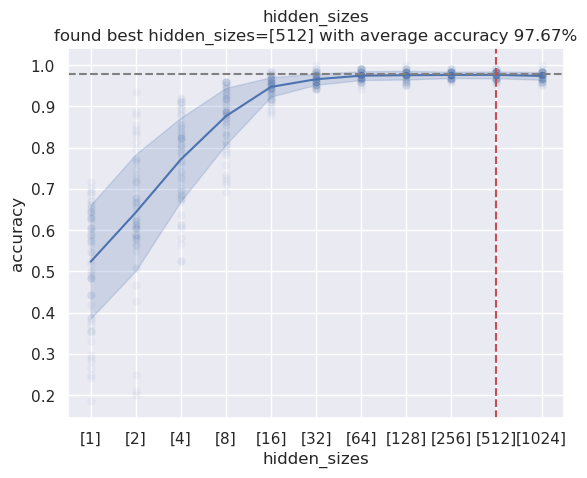

In [136]:
with Pool(THREADS) as pool:
    plot_factor_dependency('hidden_sizes', [[2 ** i] for i in range(0, 11)], best_args, reps=64, pool=pool, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

Since the value of 64 the line on the graph is constant so the best value is bound to be between 64 and 512 for 32 repetitions for the model.

This means that increasing the number of neurons in the hidden layer beyond 64 doesn't lead to any significant improvement in the model's performance. Therefore, it is reasonable to conclude that the optimal value for the hidden layer size lies within the range of 64 to 512 for this specific model and dataset.

Conclusion with other hyperparameters:


- Learning Rate: A larger network (with more neurons or layers) might require a smaller learning rate, as the updates could be more volatile with a larger network.

- Batch Size: Larger networks might benefit from a larger batch size, as this offers more stable gradients. On the other hand, smaller batch sizes provide a regularizing effect and could help to avoid overfitting on larger networks.

- Number of Epochs: Larger networks usually require more epochs to train as there are more parameters to optimize.

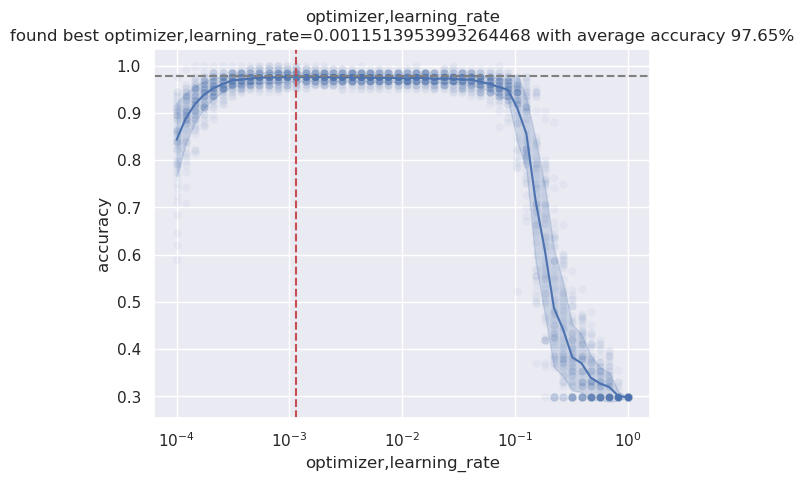

In [153]:
with Pool(THREADS) as pool:
    plot_factor_dependency('optimizer,learning_rate', np.logspace(-4, 0, base=10, num=50), best_args, reps=64, pool=pool, xlog=True, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

After performing an optimization process on the learning rate for the Adam optimizer, the best learning rate found is 0.00115. The average accuracy achieved with this learning rate is 97.64%.

A learning rate of 0.00115 appears to be a good balance for this model. It's small enough to ensure the model doesn't overshoot the minimum but is also large enough that the model learns in a reasonable amount of time, avoiding unnecessarily long training periods.

The accuracy achieved using this learning rate is quite high, with the model correctly predicting the class almost 98% of the time, which is an excellent result.

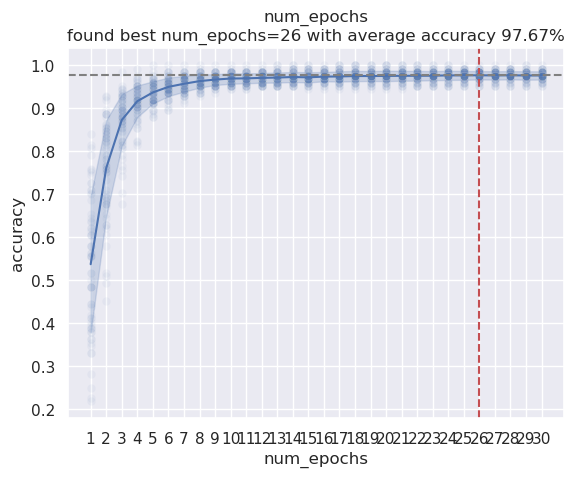

In [139]:
with Pool(THREADS) as pool:
    plot_factor_dependency('num_epochs', np.arange(1, 31), best_args, reps=64, pool=pool, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

The best performance observed during the 32 repetitions of the model was achieved at 26 epochs, with an accuracy score of 97%. This indicates that, while the model generally stabilizes after 14 epochs, allowing it to train for additional epochs can potentially lead to better performance. This suggests that most of the learning happens within these initial epochs and further training on more epochs does not contribute to an increase in model accuracy.

Given these insights, a reasonable strategy for this model might be to use early stopping, a technique where you stop training as soon as the validation performance stops improving, possibly with a patience of around 12 epochs. This can prevent overfitting while also saving computational resources by avoiding unnecessary epochs.

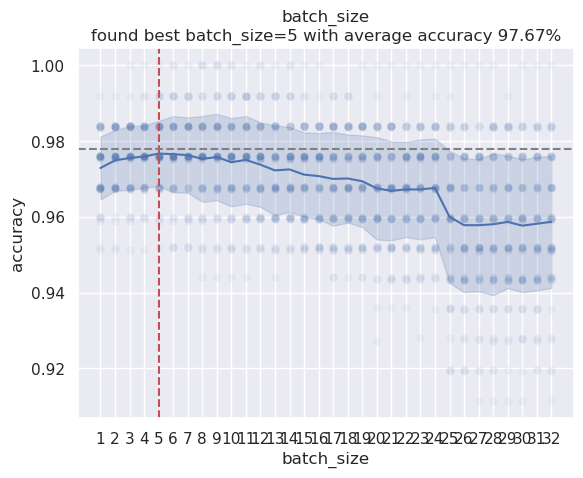

In [140]:
with Pool(THREADS) as pool:
    plot_factor_dependency('batch_size', np.arange(1, 33), best_args, reps=64, pool=pool, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

The best batch size was found to be 5, which led to an average accuracy score of approximately 97% over 32 repetitions of the model. 

A smaller batch size has the advantage of making the network update its weights more often, leading to a faster convergence to the optimal set of weights. This can lead to a higher accuracy in some cases, as observed in my results.

# Test model on test set

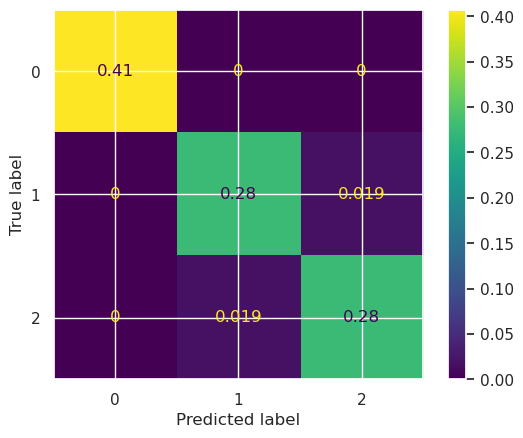

In [168]:
model = instantialize_from_args(best_args)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_preds, normalize="all")

From the diagonal of the matrix, we can see the number of correct predictions the model made for each class:

- For class 0, the model predicted correctly 0.41 of the time.
- For class 1, the model predicted correctly 0.28 of the time.
- For class 2, the model predicted correctly 0.28 of the time.

The off-diagonal elements in the matrix represent the errors made by the model:

- The model incorrectly predicted class 2 as class 1, 0.019 of the time.
- Similarly, it misclassified class 1 as class 2, 0.019 of the time.

The model made no errors predicting class 0, and it never confused class 0 with either of the other two classes.

The classes 1 and 2 had some overlap, as indicated by the non-zero off-diagonal elements. This could mean that these classes have similar features that can make them harder to distinguish.

In conclusion, the model performed very well with class 0, having 100% accuracy. For classes 1 and 2, there were some misclassifications. Further feature engineering, more data collection, or fine-tuning of model parameters might improve the model's ability to distinguish between classes 1 and 2. Despite this, the overall performance of the model appears to be satisfactory, but there is room for improvement.

# Calculated Metrics

In [163]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.94      0.94      0.94        16
           2       0.94      0.94      0.94        16

    accuracy                           0.96        54
   macro avg       0.96      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



In [175]:
tn, fp, fn, tp = confusion_matrix(y_test > 0, y_preds > 0).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print('Specificity : ', specificity)
print('Sensitivity : ', sensitivity)

Specificity :  1.0
Sensitivity :  1.0


Clasification report:

- The classification report provides a breakdown of the model's performance on each class.

- For class 0, the model achieved a precision, recall, and F1-score of 1.00. This means the model perfectly identified all instances of class 0 - it made no false positives (precision) or false negatives (recall), and consequently, the F1-score (the harmonic mean of precision and recall) is also perfect.

- For classes 1 and 2, the precision, recall, and F1-score are all 0.94, indicating a very good, though not perfect, performance. The model correctly identified 94% of the positive instances for these classes (recall), and when it predicted a positive instance, it was correct 94% of the time (precision).

- The accuracy of the model is 0.96, indicating that it correctly classified 96% of all instances.

Specificity and Sensitivity measures:

- Specificity, also known as the true negative rate, measures the proportion of actual negatives that are correctly identified as such. In this case, the specificity is 1.0, indicating that all actual negatives were correctly identified by the model.

- Sensitivity, also known as the true positive rate or recall, measures the proportion of actual positives that are correctly identified as such. The sensitivity is 1.0, indicating that all actual positives were correctly identified by the model.


# Comparing implemented NN model with other ML models

For each of my models, I'm putting them through a rigorous workout with stratified 5-fold cross-validation using StratifiedKFold. This way, each model gets a fair and balanced training and validation set. Next I plot and print the result.

In [171]:
best_args = {'hidden_sizes': [128],
  'batch_size': 7,
  'num_epochs': 25,
  'optimizer': {'name': 'Adam',
   'learning_rate': 0.001,
   'beta1': 0.4828766300042446,
   'beta2': 0.9780262776787818}
            }

Support Vector Classifier Accuracy: 0.6853 +/- 0.0474
K-Nearest Neighbors Accuracy: 0.6710 +/- 0.1259
Gaussian Naive Bayes Accuracy: 0.9840 +/- 0.0196
Decision Tree Accuracy: 0.9193 +/- 0.0253
Random Forest Accuracy: 0.9917 +/- 0.0167
Neural Network model Accuracy: 0.9597 +/- 0.0253


Text(0.5, 1.0, 'Comparison of Classifier Accuracies on Wine Dataset')

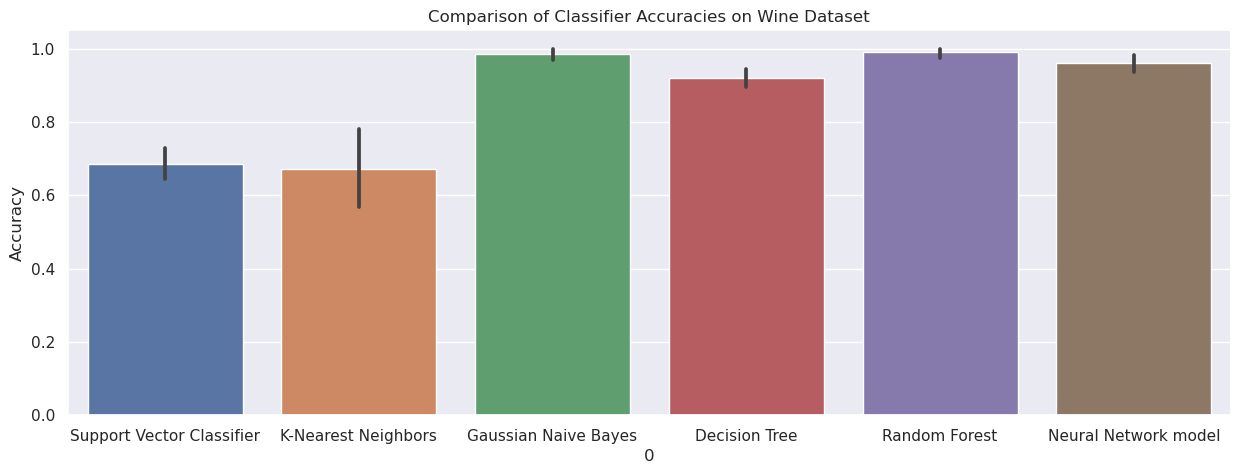

In [173]:
classifiers = [
    ('Support Vector Classifier', lambda: SVC(random_state=42)),
    ('K-Nearest Neighbors', lambda: KNeighborsClassifier()),
    ('Gaussian Naive Bayes', lambda: GaussianNB()),
    ('Decision Tree', lambda: DecisionTreeClassifier(random_state=42)),
    ('Random Forest', lambda: RandomForestClassifier(random_state=42)),
    ('Neural Network model', lambda: instantialize_from_args(best_args)),
]

accuracies = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for name, clf_cls in classifiers:
    accuracies.append([])
    for train_idx, val_idx in skf.split(X_train, y_train):
        clf = clf_cls()
        clf.fit(X_train[train_idx], y_train[train_idx])
        Y_pred = clf.predict(X_train[val_idx])
        accuracy = accuracy_score(y_train[val_idx], Y_pred)
        accuracies[-1].append(accuracy)
    print(f"{name} Accuracy: {np.mean(accuracies[-1]):.4f} +/- {np.std(accuracies[-1]):.4f}")

names, acc_values = zip(*classifiers)
plt.figure(figsize=(15,5))
sns.barplot(data=pd.DataFrame([(name, acc) for name, accs in zip(names, accuracies) for acc in accs]), x=0, y=1)
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies on Wine Dataset')

The results depict the comparative performance of various classification algorithms on the Wine Dataset:

- Support Vector Classifier: With an average accuracy of 68.53% and a standard deviation of 0.0474, the Support Vector Classifier (SVC) performance is moderate. SVC usually requires tuning of parameters and normalization of data to improve its accuracy.

- K-Nearest Neighbors: K-Nearest Neighbors (KNN) has similar accuracy to SVC, around 67.1%. However, its performance is more variable with a standard deviation of 0.1259, which might indicate that the model performance could be quite sensitive to the choice of training and validation sets.

- Gaussian Naive Bayes: The Gaussian Naive Bayes classifier demonstrates excellent performance, achieving an average accuracy of 98.4%. This model assumes that features are independent, which seems to be a reasonable assumption for this dataset.

- Decision Tree: The Decision Tree classifier offers good performance with an average accuracy of 91.93%. This suggests that the features in the dataset may have good predictive power and that they might be reasonably well separated in feature space.

- Random Forest: The Random Forest model, which is an ensemble of decision trees, shows the best performance with an average accuracy of 99.17%. This is a significant improvement over a single decision tree and illustrates the power of ensemble methods.

- Neural Network model: This model shows a very high performance with an accuracy of approximately 95.97%, which is quite competitive but slightly less than the Random Forest and Gaussian Naive Bayes models.

In conclusion, while all models provided a reasonable level of accuracy, the Gaussian Naive Bayes and Random Forest models showed exceptional performance on this dataset. The choice between these two models could then depend on other factors such as computational cost or interpretability, my self implemented model is not good enought for this dataset.